In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets, models
from torch.utils.data import Dataset, DataLoader
from torch.autograd import Variable
from collections import OrderedDict
import matplotlib.pyplot as plt
import time
import copy
import os
import cv2
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
from os import listdir 
from itertools import chain 
from PIL import Image, ImageOps
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(torch.cuda.get_device_name(0))

Tesla T4


In [3]:
batch_size = 64

transforms = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(root='/kaggle/input/mix-fashion-mnist/Dataset-Fix/Train', transform=transforms)
test_dataset = datasets.ImageFolder(root='/kaggle/input/mix-fashion-mnist/Dataset-Fix/Test', transform=transforms)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

In [4]:
data_size = len(train_dataset), len(test_dataset)
data_size

(22000, 4400)

In [5]:
def output_label(label):
    output_mapping = {
                 0: "Ankle Boot",
                 1: "Bag",
                 2: "Coat",
                 3: "Dress",
                 4: "Hat",
                 5: "Pullover", 
                 6: "Sandal", 
                 7: "Shirt",
                 8: "Sneaker",
                 9: "T-Shirt",
                 10: "Trouser"
                 }
    input = (label.item() if type(label) == torch.Tensor else label)
    return output_mapping[input]

images-size: torch.Size([64, 3, 64, 64])
out-size: torch.Size([3, 530, 530])


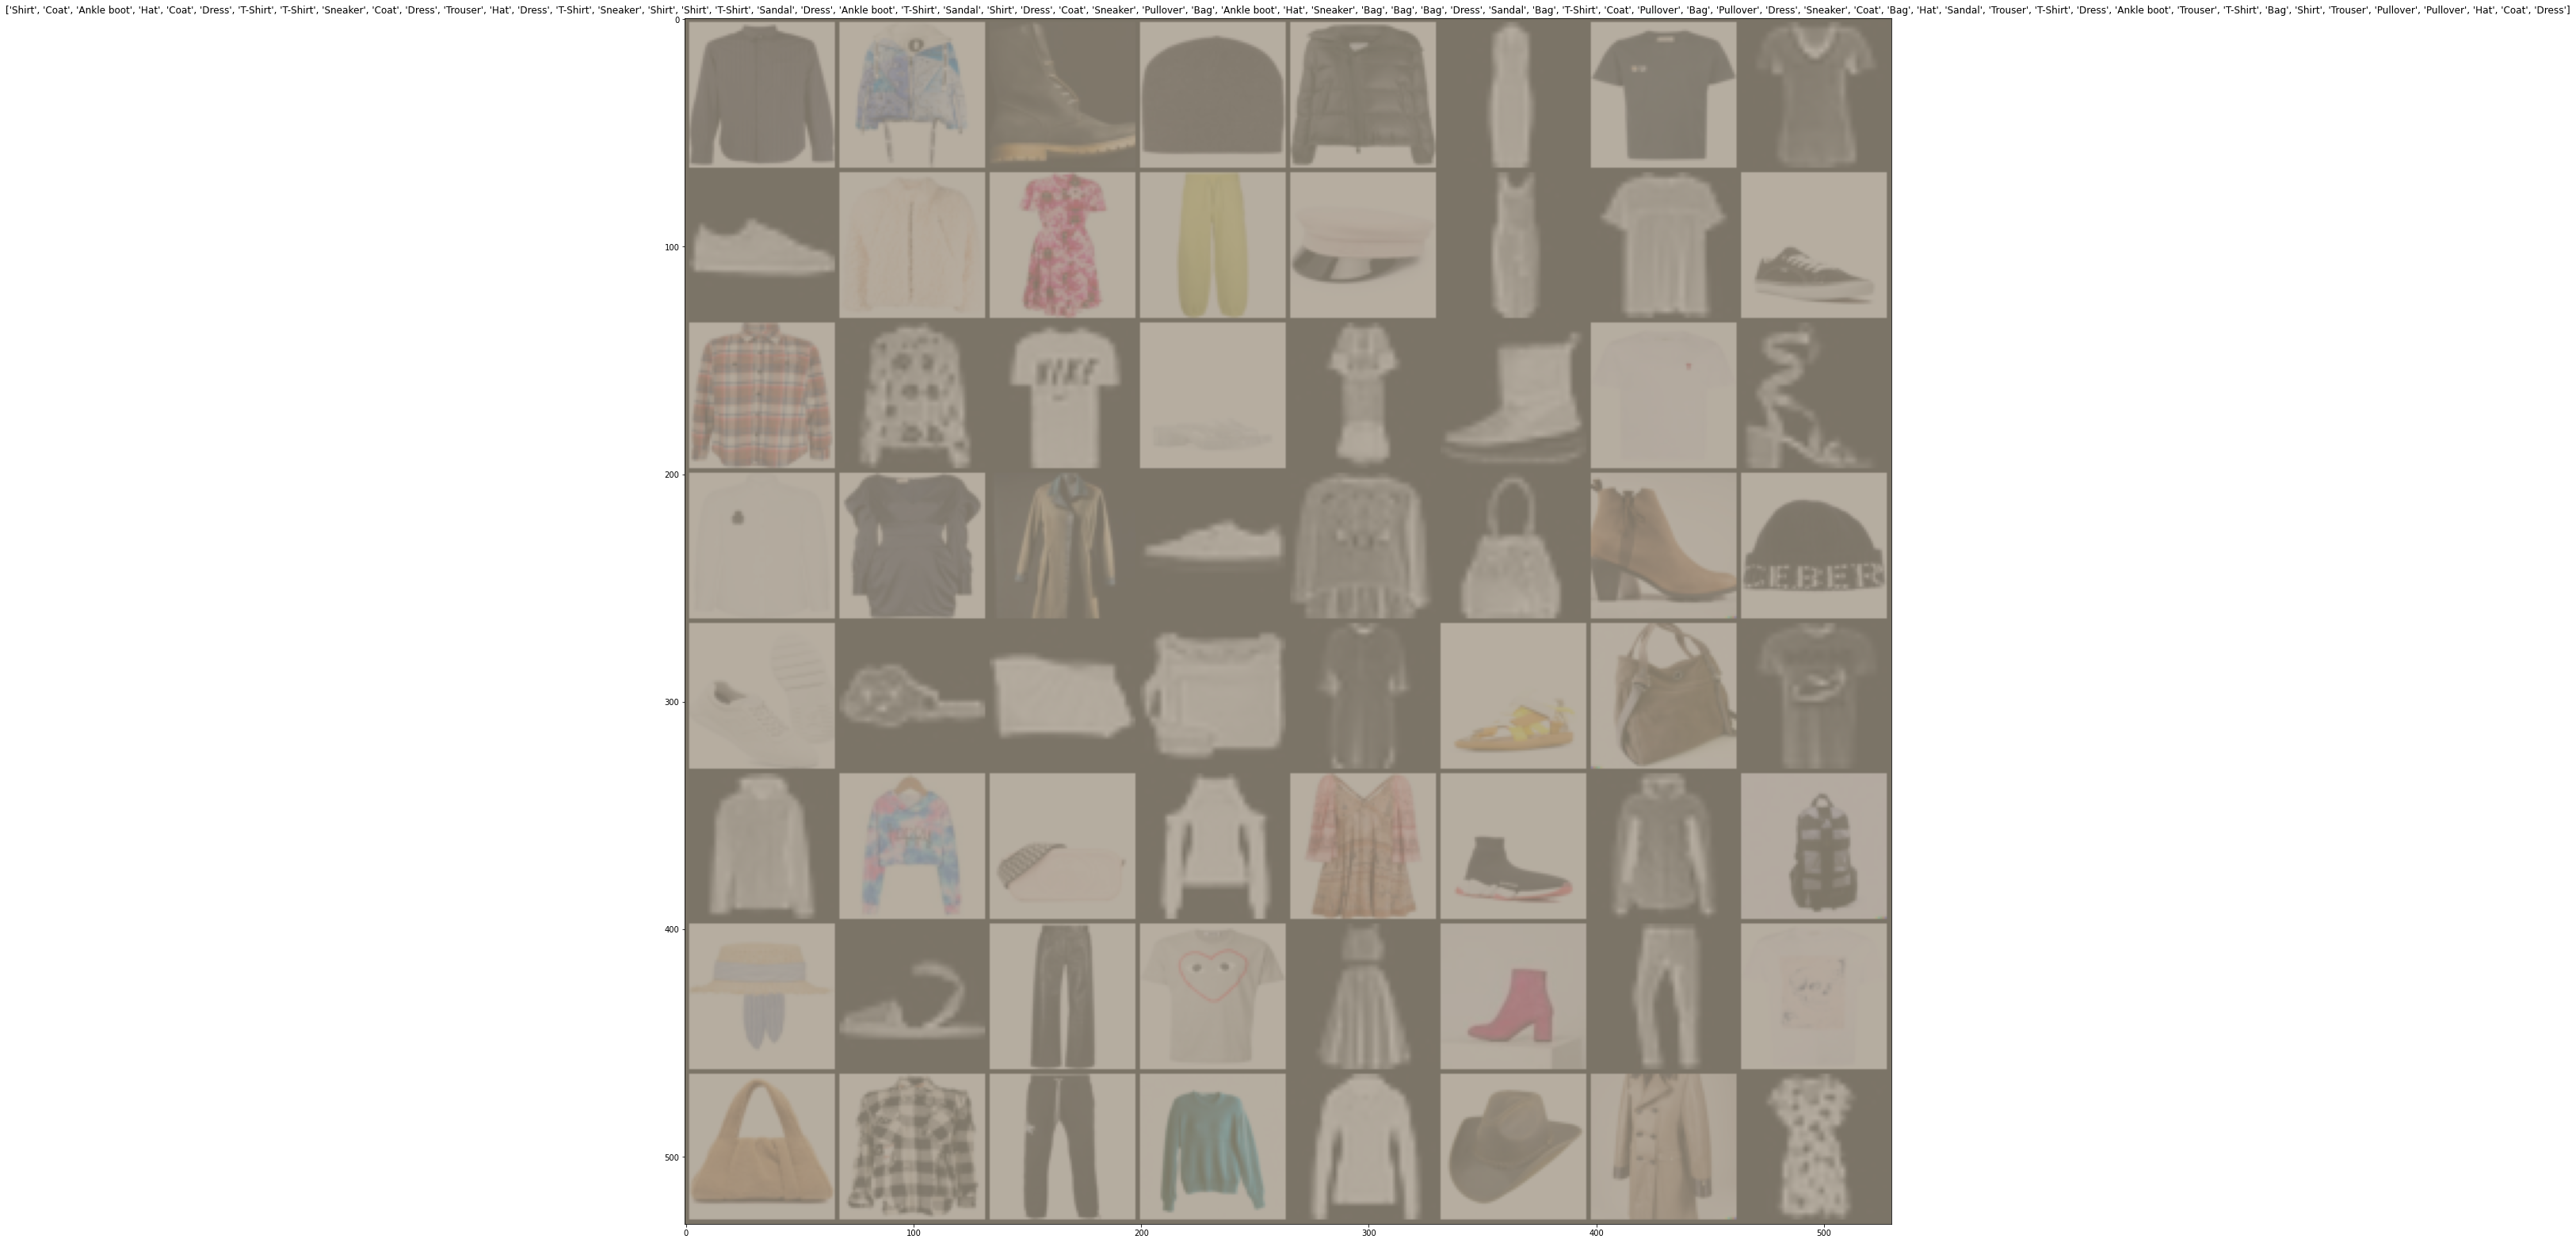

In [6]:
def imshow(inp, title=None):
    
    inp = inp.cpu() if device else inp
    inp = inp.numpy().transpose((1, 2, 0))
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    
    plt.figure(figsize=(28,28))
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)
    
images, labels = next(iter(train_dataloader)) 
print("images-size:", images.shape)

out = torchvision.utils.make_grid(images)
print("out-size:", out.shape)

imshow(out, title=[train_dataset.classes[x] for x in labels])

In [6]:
net = models.vgg16(pretrained=True)
net

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [7]:
for param in net.parameters():
    param.requires_grad = False

In [8]:
net.classifier

Sequential(
  (0): Linear(in_features=25088, out_features=4096, bias=True)
  (1): ReLU(inplace=True)
  (2): Dropout(p=0.5, inplace=False)
  (3): Linear(in_features=4096, out_features=4096, bias=True)
  (4): ReLU(inplace=True)
  (5): Dropout(p=0.5, inplace=False)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)

In [9]:
newClassifier = nn.Sequential(
    OrderedDict([
        ('fc1', nn.Linear(25088, 4096)),
        ('relu', nn.ReLU()),
        ('drop', nn.Dropout(p = 0.5)),
        ('fc2', nn.Linear(4096, 11)),
        ('output', nn.LogSoftmax(dim = 1))
    ])
)

In [10]:
net.classifier = newClassifier
net.classifier

Sequential(
  (fc1): Linear(in_features=25088, out_features=4096, bias=True)
  (relu): ReLU()
  (drop): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=4096, out_features=11, bias=True)
  (output): LogSoftmax(dim=1)
)

In [11]:
net = net.to(device)
net

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [13]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.0001)

In [14]:
def train(num_epochs=5):
  train_loss = []
  train_accuracy = []

  val_loss = []
  val_accuracy = []

  predictions_list = []
  labels_list = []

  best_loss = .5
  best_accuracy = 0

  start = time.time()
  for epoch in range(num_epochs):
    print(f'Epoch: {epoch+1}/{num_epochs}')
    print('-' * 10)

    train_correct = 0
    val_correct = 0


    for X_train, y_train in train_dataloader:
      net.train()
      X_train, y_train = X_train.to(device), y_train.to(device)

      y_pred = net(X_train)
      loss = criterion(y_pred, y_train)

      predicted = torch.max(y_pred.data, 1)[1]
      train_correct += (predicted == y_train).sum()/data_size[0]

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    train_loss.append(loss.detach().cpu().numpy())
    train_accuracy.append(train_correct.detach().cpu().numpy())

    print(f'loss: {loss}\naccuracy: {train_correct}\n')

    with torch.no_grad():
      for X_test, y_test in test_dataloader:
        net.eval()
        X_test, y_test = X_test.to(device), y_test.to(device)

        labels_list.append(y_test)

        y_val = net(X_test)

        predicted = torch.max(y_val.data, 1)[1]
        predictions_list.append(predicted)
        val_correct += (predicted == y_test).sum()/data_size[1]
    
    loss = criterion(y_val, y_test)
    val_loss.append(loss.detach().cpu().numpy())
    val_accuracy.append(val_correct.detach().cpu().numpy())
    print(f'val_loss: {loss}\nval_accuracy: {val_correct}\n\n')

    if best_accuracy < val_correct:
      if best_loss > loss:
        best_loss = loss
        best_accuracy = val_correct
        best_net = copy.deepcopy(net)

  end = time.time() - start

  print('-' * 10)
  print(f'Training time taken: {int(end/60)}min {int(end%60)}sec\n')
  print(f'Best val_accuracy: {best_accuracy}')
  print(f'Lowest val_loss: {best_loss}')

  return best_net, [train_loss, train_accuracy, val_loss, val_accuracy], [predictions_list, labels_list]

In [16]:
trained_model, result, preds_and_labels = train(25)

Epoch: 1/25
----------
loss: 0.3053145110607147
accuracy: 0.8811812400817871

val_loss: 0.24860595166683197
val_accuracy: 0.8631812930107117


Epoch: 2/25
----------
loss: 0.4009052515029907
accuracy: 0.8952721953392029

val_loss: 0.6302352547645569
val_accuracy: 0.8640903830528259


Epoch: 3/25
----------
loss: 0.20935235917568207
accuracy: 0.9069539904594421

val_loss: 0.2878933250904083
val_accuracy: 0.866135835647583


Epoch: 4/25
----------
loss: 0.15891730785369873
accuracy: 0.9153631925582886

val_loss: 0.40945330262184143
val_accuracy: 0.8768176436424255


Epoch: 5/25
----------
loss: 0.2780969440937042
accuracy: 0.9224991202354431

val_loss: 0.3278549909591675
val_accuracy: 0.8731812834739685


Epoch: 6/25
----------
loss: 0.06470183283090591
accuracy: 0.928317666053772

val_loss: 0.3834390640258789
val_accuracy: 0.8793176412582397


Epoch: 7/25
----------
loss: 0.23541545867919922
accuracy: 0.9355899691581726

val_loss: 0.363170862197876
val_accuracy: 0.881817638874054


Epoc

In [17]:
train_loss = result[0]
train_accuracy = result[1]

val_loss = result[2]
val_accuracy = result[3]

dictionary = {
    'train_loss':train_loss,
    'train_accuracy':train_accuracy,
    'val_loss':val_loss,
    'val_accuracy':val_accuracy
}
metrics = pd.DataFrame(dictionary)
metrics

,train_loss,train_accuracy,val_loss,val_accuracy
0,0.3053145,0.88118124,0.24860595,0.8631813
1,0.40090525,0.8952722,0.63023525,0.8640904
2,0.20935236,0.906954,0.28789333,0.86613584
3,0.15891731,0.9153632,0.4094533,0.87681764
4,0.27809694,0.9224991,0.327855,0.8731813
5,0.06470183,0.92831767,0.38343906,0.87931764
6,0.23541546,0.93558997,0.36317086,0.88181764
7,0.079609856,0.9433631,0.38789132,0.87840855
8,0.17058523,0.94081753,0.12232512,0.8786358
9,0.14287128,0.9509084,0.6863866,0.8770449


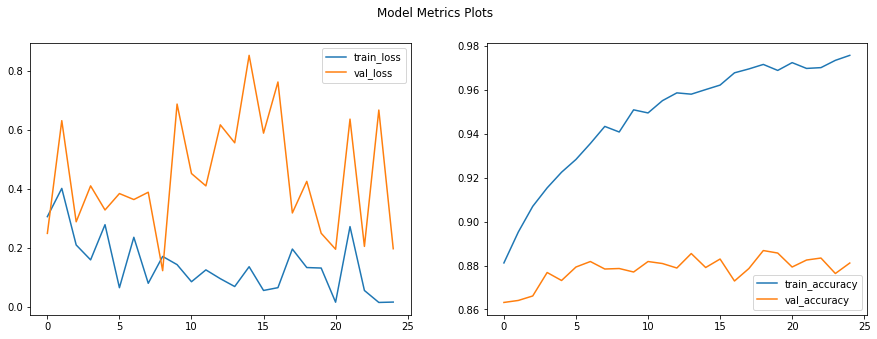

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle('Model Metrics Plots')

ax1.plot(metrics[['train_loss', 'val_loss']])
ax1.legend(['train_loss', 'val_loss'], loc="upper right")

ax2.plot(metrics[['train_accuracy', 'val_accuracy']])
ax2.legend(['train_accuracy', 'val_accuracy'], loc="lower right");

In [19]:
class_correct = [0. for _ in range(11)]
total_correct = [0. for _ in range(11)]

with torch.no_grad():
    for images, labels in test_dataloader:
        images, labels = images.to(device), labels.to(device)
        test = Variable(images)
        outputs = trained_model(test)
        predicted = torch.max(outputs, 1)[1]
        c = (predicted == labels).squeeze()
        
        for i in range(10):
            label = labels[i]
            class_correct[label] += c[i].item()
            total_correct[label] += 1
        
for i in range(11):
    print("Accuracy of {}: {:.2f}%".format(output_label(i), class_correct[i] * 100 / total_correct[i]))

Accuracy of Ankle Boot: 100.00%
Accuracy of Bag: 91.80%
Accuracy of Coat: 76.19%
Accuracy of Dress: 91.04%
Accuracy of Hat: 98.48%
Accuracy of Pullover: 89.06%
Accuracy of Sandal: 96.30%
Accuracy of Shirt: 71.43%
Accuracy of Sneaker: 78.69%
Accuracy of T-Shirt: 94.74%
Accuracy of Trouser: 94.74%


In [20]:
predictions_list = preds_and_labels[0]
labels_list = preds_and_labels[1]

predictions_l = [predictions_list[i].tolist() for i in range(len(predictions_list))]
labels_l = [labels_list[i].tolist() for i in range(len(labels_list))]
predictions_l = list(chain.from_iterable(predictions_l))
labels_l = list(chain.from_iterable(labels_l))

In [37]:
print("Classification report for model :\n", classification_report(labels_l, predictions_l))

Classification report for model :
               precision    recall  f1-score   support

           0       0.94      0.94      0.94     10000
           1       0.95      0.93      0.94     10000
           2       0.77      0.80      0.78     10000
           3       0.87      0.90      0.89     10000
           4       0.96      0.98      0.97     10000
           5       0.82      0.81      0.82     10000
           6       0.90      0.90      0.90     10000
           7       0.73      0.68      0.70     10000
           8       0.89      0.89      0.89     10000
           9       0.85      0.87      0.86     10000
          10       0.97      0.95      0.96     10000

    accuracy                           0.88    110000
   macro avg       0.88      0.88      0.88    110000
weighted avg       0.88      0.88      0.88    110000



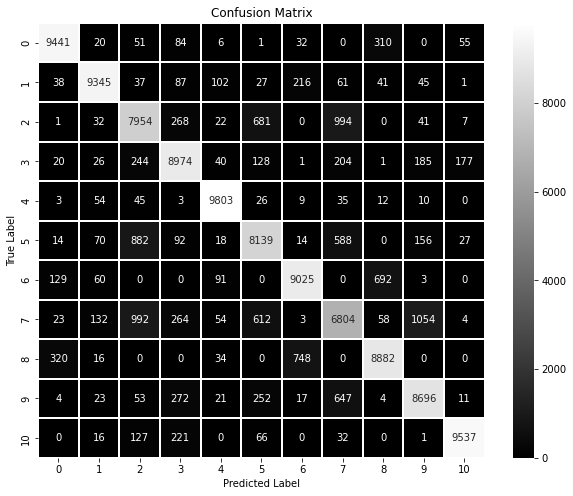

In [22]:
confusion_mtx = confusion_matrix(labels_l, predictions_l) 

f,ax = plt.subplots(figsize = (10, 8))
sns.heatmap(confusion_mtx, annot=True, linewidths=0.1, cmap = "gist_yarg_r", linecolor="white", fmt='.0f', ax=ax)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [12]:
#torch.save(trained_model, 'model_vgg16.pt')

#Load Model
PATH = "/model/model_vgg16.pt"
weights = torch.load(PATH)
net.load_state_dict(weights)
sirius_model = net.eval()

In [13]:
import torchvision.transforms as transforms
image_transforms = transforms.Compose([
        transforms.Resize((64,64)),
        transforms.ToTensor()
])

In [14]:
def custom_image_pred(model, image_transforms, image_path, labels_data):
  image = Image.open(image_path).convert('RGB')

  resize_image = image.resize((64, 64))  
  
  image = image_transforms(image).float()
  image = image.unsqueeze(0).to(device)

  output = model(image)
  probs = F.softmax(output, dim=1)
  conf, classes = torch.max(probs, 1)

  return labels_data[classes.item()], round(conf.item(), 3), resize_image

In [15]:
labels_data = {
                 0: "Ankle Boot",
                 1: "Bag",
                 2: "Coat",
                 3: "Dress",
                 4: "Hat",
                 5: "Pullover", 
                 6: "Sandal", 
                 7: "Shirt",
                 8: "Sneaker",
                 9: "T-Shirt",
                 10: "Trouser"
                 }

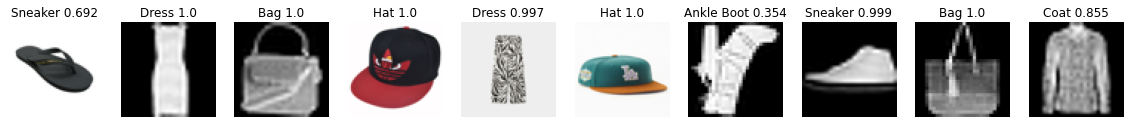

In [16]:
folder_dir = "/kaggle/input/jury-test/Jury Test Set"
image_list = []

for images in listdir(folder_dir):
    if (images.endswith(".png") or images.endswith(".jpg") or images.endswith(".jpeg")):
      image_list.append(str(folder_dir+"/"+images))

fig = plt.figure(figsize=(20, 8))
cols, rows = len(image_list), 1

for i in range(1, cols * rows + 1):
    labels_pred, conf, image = custom_image_pred(sirius_model, image_transforms, image_list[i-1], labels_data)
    
    fig.add_subplot(rows, cols, i)
    plt.title(f'{labels_pred} {conf}')
    plt.axis('off')
    plt.imshow(image)
plt.show()

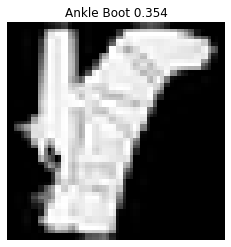

In [17]:
labels_pred, conf, image = custom_image_pred(sirius_model, image_transforms, '/kaggle/input/jury-test/Jury Test Set/mnist_11_shoes.png', labels_data)

fig.add_subplot(rows, cols, i)
plt.title(f'{labels_pred} {conf}')
plt.axis('off')
plt.imshow(image);